In [200]:
!pip install ffmpeg --upgrade

  Created wheel for ffmpeg: filename=ffmpeg-1.4-py3-none-any.whl size=6084 sha256=014b742dff1ddcb8f450d7d0e3533c0397a906e3869ecb24e26eee499e4b52f3
  Stored in directory: c:\users\jack hardwick\appdata\local\pip\cache\wheels\1d\57\24\4eff6a03a9ea0e647568e8a5a0546cdf957e3cf005372c0245
Successfully built ffmpeg

In [204]:
import pandas as pd
import numpy as np
import scipy
import pretty_midi as pm
import matplotlib.pyplot as plt
import librosa
import librosa.display
import math
import itertools
from IPython.display import Audio
from IPython.display import Video
import time
import soundfile as sf
import subprocess
import matplotlib.animation as anim
import moviepy.editor as mp

In [40]:
!python data_cleaning.py -i "solar_wind_data_2003-10-27 - 2003-11-02 1min.xlsx" -o "cleaned_data.csv"

In [205]:
class Sonify:
  
  def read_data(self, input_path, output_path): 
    """Read the data from the given csv file path."""

    try:
      if not output_path.endswith(".csv"): # If provided path is not a valid csv file
        print("Invalid file path. Must be .csv file.")
        raise FileNotFoundError()
      else:
        self.df = pd.read_csv(output_path) # Loads csv file
        print("Dataset loaded correctly:", output_path)

      # Constants used to create Kp comparison value
      self.density_max = np.max(self.df["proton_density"])
      self.speed_max = np.max(self.df["speed"])
      self.dataset_len = len(self.df.index)

    except Exception as e:
      if e.__class__ == FileNotFoundError:
        print("No valid .csv file found at specified path. Please verify filepath.")
      else:
        print("Error:", e.__class__)

  def __raw_data_cleanup(self, input_path, output_path):
    """Runs script to clean up raw 1-minute data into 5-minute averages. Doesn't work."""
    command = "python data_cleaning.py -i '" + input_path + "' -o '" + output_path + "'"
    print(command)
    subprocess.run(command)

  def read_midi(self, path):
    """Loads the MIDI file, computes grain start points as 1/32 notes."""
    try:
      if not path.endswith(".mid"): # Checks for if the path provided is a MIDI file
        print("Invalid file path. Must be .mid file.")
        raise FileNotFoundError()
      else:
        midi_data = pm.PrettyMIDI(path) # Loads the midi file
        print('MIDI file loaded successfully:', path)

      segments = (np.array(pm.PrettyMIDI.get_beats(midi_data,start_time=0.0))) # Gets the beat locations in MIDI file in seconds
      self.midi_grain_starts = np.linspace(0, segments[-1], len(segments)*8) # Interpolates down to 1/32 note locations

      # Creates attribute for MIDI grain length as the distance between steps in self.midi_grain_starts, converted to samples
      self.midi_grain_len = int(self.midi_grain_starts[1] * self.sr)

    except Exception as e:
      if e.__class__ == FileNotFoundError:
        print("MIDI file not found. Please verify filepath.")
      else:
        print("Error:", e.__class__)

  def read_audio(self, path):
    """Read the audio from given filepath."""
    self.sr = 48000 # Initiates the sample rate for the sonification process

    # Tries to load the audio file, raises FileNotFoundError if not possible.
    try:
      if not path.endswith(".wav"):
        raise FileNotFoundError()
      else:
        self.song = librosa.load(path, sr=self.sr)[0]
        print("Audio loaded correctly:", path)

    except Exception as e:
      if e.__class__ == FileNotFoundError:
        print("Not a valid .wav file. Please verify filepath.")
      else:
        print("Error:", e.__class__)

  def __dp_grains_dataframe(self):
    """Creates the dataframe containing all datapoint grain IDs, start points and feature extraction values."""
    self.dp_grains_data = pd.DataFrame() # Data frame for grains segmented based on number of data points

    song_len_samp = self.song.size # Length of current song in samples
    self.total_grains_in_song = self.dataset_len # Number of grains in song (just the length of the dataset)
    self.dp_grain_len = math.floor(song_len_samp / self.total_grains_in_song) # The length of each grain in samples

    for i in range(self.dataset_len): # Creates one grain for each row of dataframe

      self.dp_grains_data.at[i, "grain_id"] = i # Adds grain ID to dataframe

      grain_start = i*self.dp_grain_len # Find starts sample for datapoint segmented grain
      self.dp_grains_data.at[i, "grain_start"] = grain_start # Adding grain start sample index to dataframe
      
      # Feature extraction, returns list of feature values
      feature_values = self.__extract_features_from_grain(grain_start, self.dp_grain_len)

      # Add features to dataframe
      self.dp_grains_data.at[i, "spec_band"] = feature_values[0]
      self.dp_grains_data.at[i, "rms"] = feature_values[1]
      self.dp_grains_data.at[i, "mfcc"] = feature_values[2]

  def __midi_grains_dataframe(self):
    """Creates the dataframe containing all MIDI grain IDs, start points and feature extraction values."""
    self.midi_grains_data = pd.DataFrame() # Data frame for grains segmented based on previously segmented MIDI file 1/32 notes

    for i in range(self.dataset_len):
      self.midi_grains_data.at[i, "grain_id"] = i # Adds grain ID to dataframe
      
      grain_start = int(self.midi_grain_starts[i] * self.sr) # Find starts sample for MIDI segmented grain
      self.midi_grains_data.at[i, "grain_start"] = grain_start # Adds grain start sample index to dataframe

      # Feature extraction, returns list of feature values
      feature_values = self.__extract_features_from_grain(grain_start, self.midi_grain_len)

      # Add features to dataframe
      self.midi_grains_data.at[i, "spec_band"] = feature_values[0]
      self.midi_grains_data.at[i, "rms"] = feature_values[1]
      self.midi_grains_data.at[i, "mfcc"] = feature_values[2]

  def build_grains_dataframes(self):
    """Utility method to create dataframes for both types of segmentation, by datapoints and by MIDI"""
    self.__dp_grains_dataframe()
    self.__midi_grains_dataframe()

  def __extract_features_from_grain(self, grain_start, grain_len):
    """Receives grain position info and computes spectral bandwidth, RMS and MFCC Librosa feature extraction. Returns results."""
    grain_start = int(grain_start)
    grain_len = int(grain_len)
    
    grain = self.song[grain_start:grain_start+grain_len] # Selecting grain data based on start and end points

    # Spectral Bandwidth
    spec_band = librosa.feature.spectral_bandwidth(y=grain, sr=self.sr, n_fft=grain_len, hop_length=grain_len, win_length=grain_len)
    
    # Root Mean Square
    rms = librosa.feature.rms(y=grain, frame_length=grain_len, hop_length=grain_len)
    
    # Mel Frequency Cepstrum Coefficients
    mfcc_coeffs = librosa.feature.mfcc(y=grain, sr=self.sr, n_mels=13, n_fft=grain_len, hop_length=grain_len, win_length=grain_len)
    mfcc = math.sqrt(np.max(mfcc_coeffs)) # Gets sqrt of largest coefficient, to make range more usable.

    return [spec_band, rms, mfcc]

  def __map_feature_iterator(self, feature_list, datapoints_list, grains_dataframe, grains_type="dp"):    
    """"Maps the provided list of features to the provided list of datapoints in the dataset via assigning grain IDs.
        Called inside the map_features() method."""
    
    try:
      if grains_type not in ["dp", "midi"]:
        raise ValueError()

      mapping_start_time = time.time()

      for i, feature in enumerate(feature_list):

        # MIDI grains data sorted by current feature
        feature_sorted = grains_dataframe[["grain_id",feature]].sort_values(by=feature, axis='index', kind="mergesort", ignore_index=True)
        # Dataset dataset by current mapped value in datapoints_list
        self.df.sort_values(by=datapoints_list[i], axis="index", kind="mergesort", ignore_index=True, inplace=True)

        grain_id_column_title = grains_type + "_" + feature + "_grain_id" # Assembling new grain id column title for self.df
        feature_sorted.columns = [grain_id_column_title, feature] # Renaming columns in feature_sorted based on new titles

        # Adds the new grain ID column to the dataset self.df
        self.df = pd.concat([self.df, feature_sorted[grain_id_column_title]], axis="columns")

        # Re-sorts sorted self.df dataset
        self.df.sort_values(by="cumulative_secs", axis="index", kind="mergesort", ignore_index=True, inplace=True)

      # Determines time to map features for the current grain type and prints the result
      mapping_exec_time = time.time() - mapping_start_time
      print("Mapping ", grains_type, "grains completed in", round(mapping_exec_time, 3), "secs")

    except Exception as e:
      if e.__class__ == ValueError:
        print("Ensure grains_type is either 'dp' or 'midi'.")
      else:
        print("Error:", e.__class__)
  
  def map_features(self):
    """Utility method which adds grain ID columns for both grain types to dataframe by calling __map_feature_iterator method"""
    feature_list = ["spec_band", "rms", "mfcc"] # Features to be mapped
    datapoints_list = ["proton_density", "bz", "ion_temp"] # Datapoints to be mapped
    
    # For datapoint grains
    grains_type = "dp"
    self.__map_feature_iterator(feature_list, datapoints_list, self.dp_grains_data, grains_type)

    # For MIDI grains
    grains_type = "midi"
    self.__map_feature_iterator(feature_list, datapoints_list, self.midi_grains_data, grains_type)

  def __sum_grains(self, list_of_grains):
    """Adds together the individual grains for each datapoint into the full grain."""
    # how do we want to compound the grains?
    # just sums them for now
    return np.sum(list_of_grains, axis=0)
    
  def scale_features(self):
    """Scale the bz and speed data fields from self.df dataset to required ranges as audio processing parameters."""
    
    # Scales Bz to between 1 and -1
    bz = self.df['bz'].copy()
    bz = bz/np.max(bz)
    self.df['bz_scaled'] = bz
    
    # Scales speed to between 0.5 and 2
    speed = self.df['speed'].copy()
    speed -= speed.min() # Scales speed to between 0 and max-min
    speed /= speed.max() # Scales speed to between 0 and 1
    speed = (speed * 1.5) + 0.5 # Scales speed to between 0.5 and 2
    self.df['speed_scaled'] = speed
    
    print('Scaling of bz and speed values complete and written to dataframe.')
    
  def __apply_bz(self, grain, i):
    """If bz is positive, apply low-pass filter. If bz is negative, apply high-pass filter.
        Uses abs(bz) to create scaled cutoff value for use in filter."""
    bz_scaled = self.df.iloc[i]['bz_scaled']
    
    normal_cutoff = (abs(bz_scaled)*0.5) + 0.01 # Generates the cutoff value for signal.butter, in range 0.01-0.5
    order = 5
    b, a = scipy.signal.butter(order, normal_cutoff, btype=('low' if bz_scaled > 0 else 'high'),
                               analog=False)
    return scipy.signal.filtfilt(b, a, grain)
    
  def __apply_speed(self, grain, i, grain_len):
    """Change playback speed based on scaled speed value in dataset."""
    speed_scaled = self.df.iloc[i]['speed_scaled'] # Gets the scaled speed value.
    grain = librosa.effects.time_stretch(grain, rate=speed_scaled) # Applies the time-stretching to the grain.
    grain = np.append(grain, grain) # Duplicates the time-stretched grain, so it still fills the grain length if it's sped up.
    grain = grain[:grain_len] # Trimming the duplicated grain to the grain length.
    
    return grain

  def __apply_phi(self, grain, i):
    """Change playback direction based on sign of phi angle value in dataset."""
    phi = self.df.iloc[i]['phi_angle']
    
    return np.flip(grain) if phi < 0 else grain

  def __simple_envelope(self, grain, grain_len):
    """Apply a simple envelope (100-sample-long fade on each end) to the grain."""
    a = np.arange(0,1,0.01) # Ramp up of the envelope
    len_a = len(a) # The length of the ramp
    flat = np.ones((grain_len-2 * len_a)) # Flat middle section of envelope (all 1 values)
    rev_a = np.flip(a) # Creating ramp down of envelope by flipping the ramp up
    env = np.append(a,flat) # Adding ramp up and flat to envelope
    env = np.append(env,rev_a) # Adding together all the pieces of the envelope

    return grain * env

  def __compound_grains(self, grains_type='dp'):
    """Finds, sums, processes and appends all relevant grains from the dataset.
      Uses grains_type string to determine whether to use datapoint or MIDI segmentation."""
    
    synth_start_time = time.time() # Used for measuring execution time of the loop.
    
    # Tries to assign the dataframe, columns and grain length based on grains_type. Generates error if invalid input.
    try:
      if grains_type == 'dp':
        cols = ['dp_spec_band_grain_id', 'dp_rms_grain_id', 'dp_mfcc_grain_id']
        grains_dataframe = self.dp_grains_data
        grain_len = self.dp_grain_len
      elif grains_type == 'midi':
        cols = ['midi_spec_band_grain_id', 'midi_rms_grain_id', 'midi_mfcc_grain_id']
        grains_dataframe = self.midi_grains_data
        grain_len = self.midi_grain_len
      else:
        raise ValueError()

    except ValueError:
      print("grains_type must be either 'dp' or 'midi'.")

    # Main loop build the output from individual summed then processed grains
    grains_attached = [] # Initialises main return list containing all audio
    window = scipy.signal.windows.hamming(grain_len) # Generates the window function to be used for windowing the grain

    for i, row in self.df.iterrows(): # Iterating through rows of the dataset
      list_grains = [] # Resets list containing the data from the song to be summed to make compound grain
      for c in cols: # Loops through columns to pull grain audio samples
        grain_start = grains_dataframe[grains_dataframe['grain_id'] == row[c]]['grain_start'].values[0] # Gets grain based on grain ID in current column
        grain_end = grain_start + grain_len # Calculates grain end point
        grain = self.song[int(grain_start):int(grain_end)] # Pulls the grain audio
        list_grains.append(grain) # Appends to list of grains for current row in data
      compound_grain = self.__sum_grains(list_grains) # Sums the selected grains using 
        
      # print(i, '/', self.total_grains_in_song, ' merging grains...', end='\r')
      
      # On each compound grain, apply processing from the mappings
      compound_grain = self.__apply_bz(compound_grain, i) # Applies lp/hp filter
      compound_grain = self.__apply_speed(compound_grain, i, grain_len) # Changes playback speed
      compound_grain = self.__apply_phi(compound_grain, i) # Changes playback direction
      
      # Simple envelope to ramp start and end
      compound_grain = compound_grain * window
      
      # Append to main output audio array
      grains_attached = np.append(grains_attached, compound_grain)
    
    synth_exec_time = time.time() - synth_start_time
    print("Completed assembly of", grains_type, "grains in", round(synth_exec_time, 3), "secs")

    return grains_attached

  def synthesise_both(self):
    """Utility method to assemble both types of segmentation"""
    self.dp_synth = self.__normalise(self.__compound_grains("dp"))
    self.midi_synth = self.__normalise(self.__compound_grains("midi"))

    return (self.dp_synth, self.midi_synth)

  def __normalise(self, audio):
    """Utility method to normalise the given audio."""
    audio_max = np.max(np.abs(audio))
    norm_audio = audio*1/audio_max
    return norm_audio

  def __apply_reverb(self, path, grains_type="dp"):
    """Applies convolution reverb audios in sections of 36 grains, as Kp-index only updates every 3 hours/36 rows of dataset."""
    rev_start_time = time.time()
    
    # Allows method to determine which audio to use based on grains_type string, raises error if not valid option
    try:
      if grains_type == "dp":
        synth = self.dp_synth
        grain_len = self.dp_grain_len
      elif grains_type == "midi":
        synth = self.midi_synth
        grain_len = self.midi_grain_len
      else:
        raise ValueError()
    except ValueError as e:
      print("grains_type must be either 'dp' or 'midi'.")
      
    output_reverb = np.zeros(synth.size)
    kp_section_no_of_datapoints = 36 # Number of datapoints in a Kp section
    kp_section_len = kp_section_no_of_datapoints*grain_len # Length of a Kp section in samples
    section_window = scipy.signal.windows.tukey(kp_section_len, alpha=0.01) # Nearly rectangular Tukey window

    # Tries to load the impulse response and makes sure it is shorter than one section.
    try:
      ir = librosa.load(path, sr=self.sr, mono=True)[0] # Loads the IR
      ir = self.__normalise(ir) # Normalises the IR
      if ir.size > kp_section_len: # The IR can't be longer than the kp_section, so this checks.
        raise ValueError()

    except Exception as e:
      if e.__class__ == ValueError: # If the IR is too long, just return the un-reverbed audio
        print("You must use an impulse response that is shorter than", kp_section_len/self.sr, ".")
        print("Returning non-reverbed audio...")
        return synth
      elif e.__class__ == FileNotFoundError: # If the IR isn't a valid .wav, just return the un-reverbed audio.
        print("Your impulse response must be a valid .wav file.")
        print("Returning non-reverbed audio...")
        return synth
      else:
        print("Error:", e.__class__)
        print("Returning non-reverbed audio...")
        return synth

    ir_padded = np.pad(ir, (0, kp_section_len - ir.size)) # Padding the IR to the same size as the section

    for i in range(0, self.dataset_len, kp_section_no_of_datapoints): # Loop for number of sections
      kp_section_start = i*grain_len # Start point in samples of current section
      kp_section = synth[kp_section_start:kp_section_start + kp_section_len] # Gets the actual section data

      if kp_section.size < ir_padded.size: # Edge case for final section, as padded IR array may be longer than remaining data
        np.pad(kp_section, (0, ir_padded.size - kp_section.size)) # Pads final section to length of padded IR

      ir_scale_factor = self.df.at[i, "kp_index"] / 9
      dry_scale_factor = 1 - ir_scale_factor # Creates a scale factor for dry signal, which is the inverse of ir_scale_factor
      ir_padded_scaled = ir_padded * ir_scale_factor # Scaling the IR based on Kp index

      Kp_Section = scipy.fft.fft(kp_section) # FFT of the kp_section
      Ir_Padded_Scaled = scipy.fft.fft(ir_padded_scaled) # FFT of the padded scaled IR

      Kp_Section_Reverb = Kp_Section * Ir_Padded_Scaled # Frequency domain multiplication

      kp_section_reverb = np.real(scipy.fft.ifft(Kp_Section_Reverb)) # Returns the real section in the time domain

      kp_section_mix = kp_section_reverb + (dry_scale_factor*kp_section) # Adding some of the dry signal back in for makeup gain

      kp_section_mix_windowed = kp_section_mix * section_window # Windows the reverbed section

      for sample_index, sample in enumerate(kp_section_mix_windowed): # Loops through mixed section
        output_index = i * grain_len + sample_index # Corresponding index in output is the previous number of sections plus the current sample number
        output_reverb[output_index] = sample # Adding mixed sample to output

    output_reverb = self.__normalise(output_reverb)

    rev_exec_time = time.time() - rev_start_time
    print("Applied reverb to", grains_type, "grains in", round(rev_exec_time, 3), "secs")

    output_filepath = "./output/" + grains_type + "_grains_output.wav"
    print("Writing output to:", output_filepath)
    sf.write(output_filepath, output_reverb, self.sr)

    return output_reverb

  def reverb_both(self, path):
    """Utility method to apply reverb to both audios."""
    dp_synth_reverb = self.__apply_reverb(path, "dp")
    midi_synth_reverb = self.__apply_reverb(path, "midi")

    return (dp_synth_reverb, midi_synth_reverb)

  def scatter_visualisation(self):
    fig, ax1, ax2 = plt.subplots(2, 1, figsize=(16,16))
    ax1.set_xlabel('Time (s)')
    ax1.set_ylabel('Grain ID')
    ax1.set_title("Datapoint Segmentation Grain Mapping")
    ax1.scatter(x=self.df['cumulative_secs'], y=self.df[['dp_spec_band_grain_id']], c='r', s=5, label="Spectral bandwidth grains")
    ax1.scatter(x=self.df['cumulative_secs'], y=self.df[['dp_rms_grain_id']], c='g', s=5, label="RMS grains")
    ax1.scatter(x=self.df['cumulative_secs'], y=self.df[['dp_mfcc_grain_id']], c='b', s=5, label="MFCC grains")
    ax1.legend()

    plt.show()

  def animate_graph(self):
    """Animation function for our dataset over 2016 datapoints. Saves the video in your directory once the cell finished running."""

    self.df_anim = self.df.copy()
    self.df_anim = self.df_anim[["proton_density", "ion_temp", "speed", "bz", "kp_index"]]
    
    # scaling data to a range of -1 to 1 for presentation
    colnames = list(self.df_anim.columns)

    # scaling values
    for column in colnames:
      self.df_anim[column] = self.df_anim[column] / np.max(self.df_anim[column])

    self.df_anim["bz"] = (self.df_anim["bz"]*0.5)+0.5
    self.df_anim["speed"] = self.df_anim["speed"] - self.df_anim["speed"].min()
    
    # creating empty lists for writing in values by animate function
    x = []
    proton_density = []
    ion_temp = []
    speed = []
    bz = []
    kp_index = []

    # counter variable for indexing
    iterator = itertools.takewhile(lambda frame: frame < 2016, itertools.count(1))

    #figure and axes
    fig = plt.figure(figsize=(16, 12), facecolor='black')
    ax = plt.subplot(frameon=False) 
    
    # define ticks
    means = self.df_anim.mean(axis=0).to_numpy()
    offsets = np.arange(0, 1.5, 0.3)
    ticks = means + offsets

    def animate(i):
        # animation function which is getting called by FuncAnimation
    
        #writing from the dataset to lists
        next_iter = next(iterator)
        x.append(next_iter)

        proton_density.append(self.df_anim['proton_density'].iat[next_iter] + offsets[0])
        ion_temp.append((self.df_anim['ion_temp'].iat[next_iter]) + offsets[1])
        speed.append((self.df_anim['speed'].iat[next_iter]) + offsets[2])
        bz.append((self.df_anim['bz'].iat[next_iter]) + offsets[3])
        kp_index.append((self.df_anim['kp_index'].iat[next_iter]) + offsets[4])

        #plotting data 
        plt.cla()

        ax.set_yticks(ticks,['Proton Density','Ion Temperature','Speed','BZ', 'KP Index'])
        ax.get_yticklabels()[0].set_color('#00CF52')
        ax.get_yticklabels()[1].set_color('#FF33EC')
        ax.get_yticklabels()[2].set_color('#B53DFF')
        ax.get_yticklabels()[3].set_color('#00C690')
        ax.get_yticklabels()[4].set_color('#88F0F1')
        
        plt.plot(x,proton_density, c='#00CF52' )
        plt.plot(x,ion_temp, c='#FF33EC')
        plt.plot(x,speed, c='#B53DFF')
        plt.plot(x,bz, c='#00C690')
        plt.plot(x,kp_index, c='#88F0F1')

        plt.ylim((0,2))
        plt.tight_layout()

    animation = anim.FuncAnimation(plt.gcf(), animate, interval=((self.dp_grain_len/self.sr) * 1000), save_count=self.dataset_len-1950)

    animation.save("data_animated.gif")

  def movie_edit(self):
    """Combines gif and audio into synced video file."""
    video = mp.VideoFileClip("data_animated.gif")
    audio = mp.AudioFileClip("./output/dp_grains_output.wav")

    # new_audio = mp.CompositeAudioClip(audio)
    # video.audio = new_audio
    # video.write_video_file("./output/dp_grain_video.mp4")

    new_clip = video.set_audio(audio)
    new_clip.write_videofile("./output/dp_grains_video.mp4")

Dataset loaded correctly: cleaned_data.csv
Audio loaded correctly: ./corpus/02_Dido White Flag.wav
MIDI file loaded successfully: ./corpus/02_Dido White Flag_adjusted_2.mid


MovieWriter ffmpeg unavailable; using Pillow instead.


Moviepy - Building video ./output/dp_grains_video.mp4.
MoviePy - Writing audio in dp_grains_videoTEMP_MPY_wvf_snd.mp3


MoviePy - Done.
Moviepy - Writing video ./output/dp_grains_video.mp4



TypeError: must be real number, not NoneType

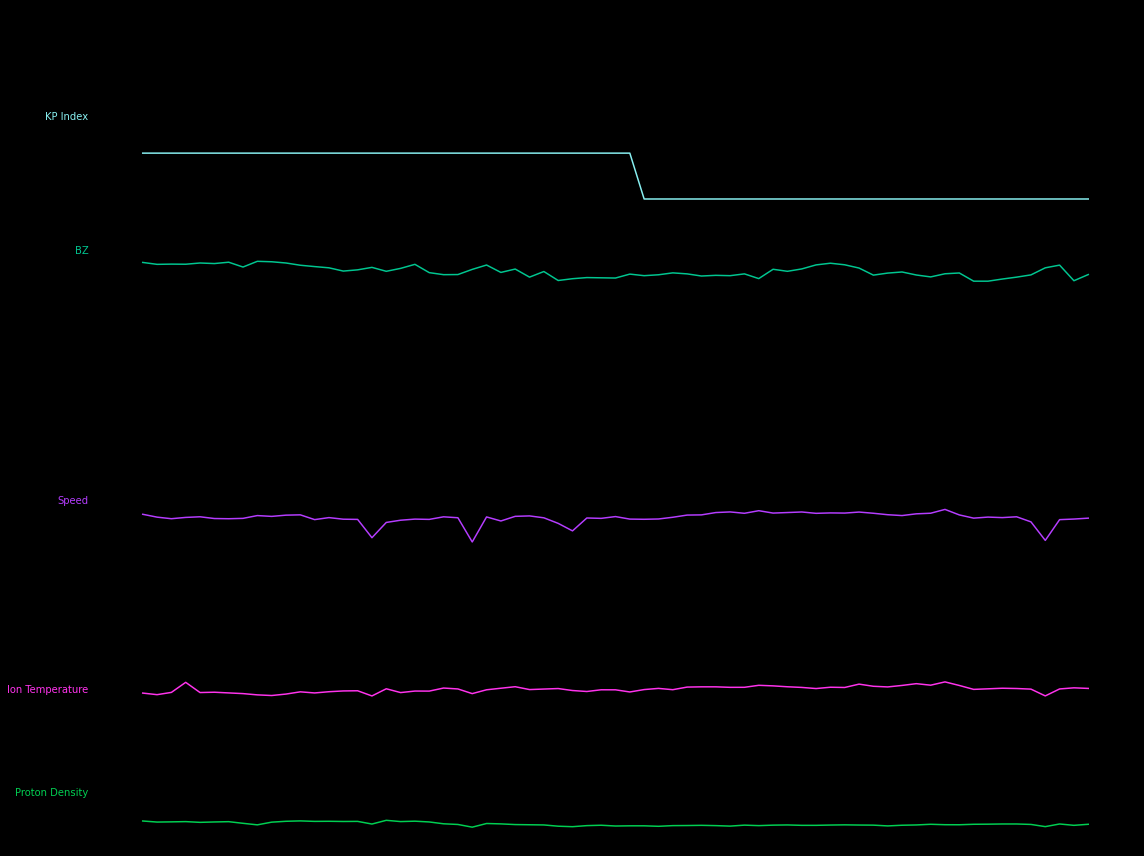

In [206]:
sonify = Sonify()

# Read dataset from csv file
sonify.read_data("solar_wind_data_2003-10-27 - 2003-11-02 1min.xlsx", "cleaned_data.csv") # solar_wind_data_2003-10-27 - 2003-11-02_ACTUAL.csv")

# Read audio from corpus
sonify.read_audio("./corpus/02_Dido White Flag.wav")

# Read MIDI from corpus
sonify.read_midi("./corpus/02_Dido White Flag_adjusted_2.mid")

# Granulate the audio by both datapoint and MIDI segmentation, and create dataframes of grain IDs and start points
sonify.build_grains_dataframes()

# # Map features from the grain dataframes to the dataset by copying across grain IDs
# sonify.map_features()

# # Scale the features used for processing parameters to suitable ranges
# sonify.scale_features()

# # Compound grains and apply mapping
# synth_outputs = sonify.synthesise_both()

# # Apply the reverb
# outputs_reverb = sonify.reverb_both("./ir/ir_sydney_cathedral.wav")

# # Display the outputs of both segmentation methods
# display(Audio(outputs_reverb[0], rate=sonify.sr))
# display(Audio(outputs_reverb[1], rate=sonify.sr))

sonify.animate_graph()

sonify.movie_edit()
